In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Proyecto1").master("local[*]").getOrCreate()
archivo = 'dataset.csv'
df_spark = spark.read.csv(archivo, inferSchema=True, header=True)


In [ ]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.streaming import StreamingContext
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.appName("AppName").getOrCreate()
spark.sparkContext.setLogLevel('WARN') #Quitar mensajes de INFO

#leer el data set conitniuo desde el csv, cambiar por streaming
df = spark.read.load('dataset.csv',
                  format='com.databricks.spark.csv',
                  header='true',
                  inferSchema='true').cache()


#valores originales
#print("Filas {0} Columnas {1}".format(df.count(), len(df.columns)))

#data cleaning
df = df.drop("x")
def replace(column, value):
    return when(column != value, column).otherwise(lit(None))







In [ ]:
df.show()

+----------+---------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+
|      Date|     Time|CO(GT)|PT08_S1(CO)|NMHC(GT)|C6H6(GT)|PT08_S2(NMHC)|NOx(GT)|PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|PT08_S5(O3)|   T|  RH|    AH|
+----------+---------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+
|10/03/2004| 18.00.00|   2.6|     1360.0|   150.0|    11.9|       1046.0|  166.0|      1056.0|  113.0|      1692.0|     1268.0|13.6|48.9|0.7578|
|10/03/2004| 19.00.00|   2.0|     1292.0|   112.0|     9.4|        955.0|  103.0|      1174.0|   92.0|      1559.0|      972.0|13.3|47.7|0.7255|
|10/03/2004| 20.00.00|   2.2|     1402.0|    88.0|     9.0|        939.0|  131.0|      1140.0|  114.0|      1555.0|     1074.0|11.9|54.0|0.7502|
|10/03/2004| 21.00.00|   2.2|     1376.0|    80.0|     9.2|        948.0|  172.0|      1092.0|  122.0|      1584.0|     1203.0|11.

In [ ]:
for x in df:
  att = str(x).split("Column<'")[1].split("'>")[0]
  df = df.withColumn(att, replace(col(att), "-200"))
  df = df.na.drop()

df.show()


+----------+---------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+
|      Date|     Time|CO(GT)|PT08_S1(CO)|NMHC(GT)|C6H6(GT)|PT08_S2(NMHC)|NOx(GT)|PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|PT08_S5(O3)|   T|  RH|    AH|
+----------+---------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+
|10/03/2004| 18.00.00|   2.6|     1360.0|   150.0|    11.9|       1046.0|  166.0|      1056.0|  113.0|      1692.0|     1268.0|13.6|48.9|0.7578|
|10/03/2004| 19.00.00|   2.0|     1292.0|   112.0|     9.4|        955.0|  103.0|      1174.0|   92.0|      1559.0|      972.0|13.3|47.7|0.7255|
|10/03/2004| 20.00.00|   2.2|     1402.0|    88.0|     9.0|        939.0|  131.0|      1140.0|  114.0|      1555.0|     1074.0|11.9|54.0|0.7502|
|10/03/2004| 21.00.00|   2.2|     1376.0|    80.0|     9.2|        948.0|  172.0|      1092.0|  122.0|      1584.0|     1203.0|11.

In [ ]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = df.select(
    _mean(col('PT08_S5(O3)')).alias('mean'),
    _stddev(col('PT08_S5(O3)')).alias('std')
).collect()

std = df_stats[0]['std']
std

400.13466248568767

In [ ]:

from pyspark import SQLContext, SparkConf, SparkContext
sc = SparkContext.getOrCreate();
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector
[str(x).split("Column<'")[1].split("'>")[0] for x in df]

['Date',
 'Time',
 'CO(GT)',
 'PT08_S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08_S2(NMHC)',
 'NOx(GT)',
 'PT08_S3(NOx)',
 'NO2(GT)',
 'PT08_S4(NO2)',
 'PT08_S5(O3)',
 'T',
 'RH',
 'AH']

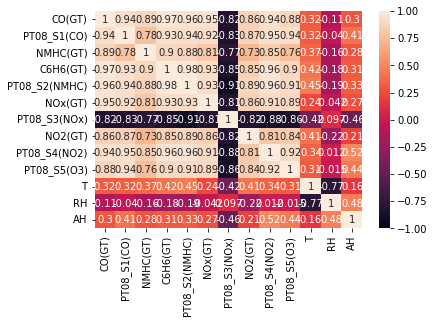

In [ ]:

from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = df.drop("Date")
df = df.drop("Time")
# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return  sns.heatmap(corr_mat_df, vmin=-1, vmax=1, annot=True)
corr = compute_correlation_matrix(df)
corr

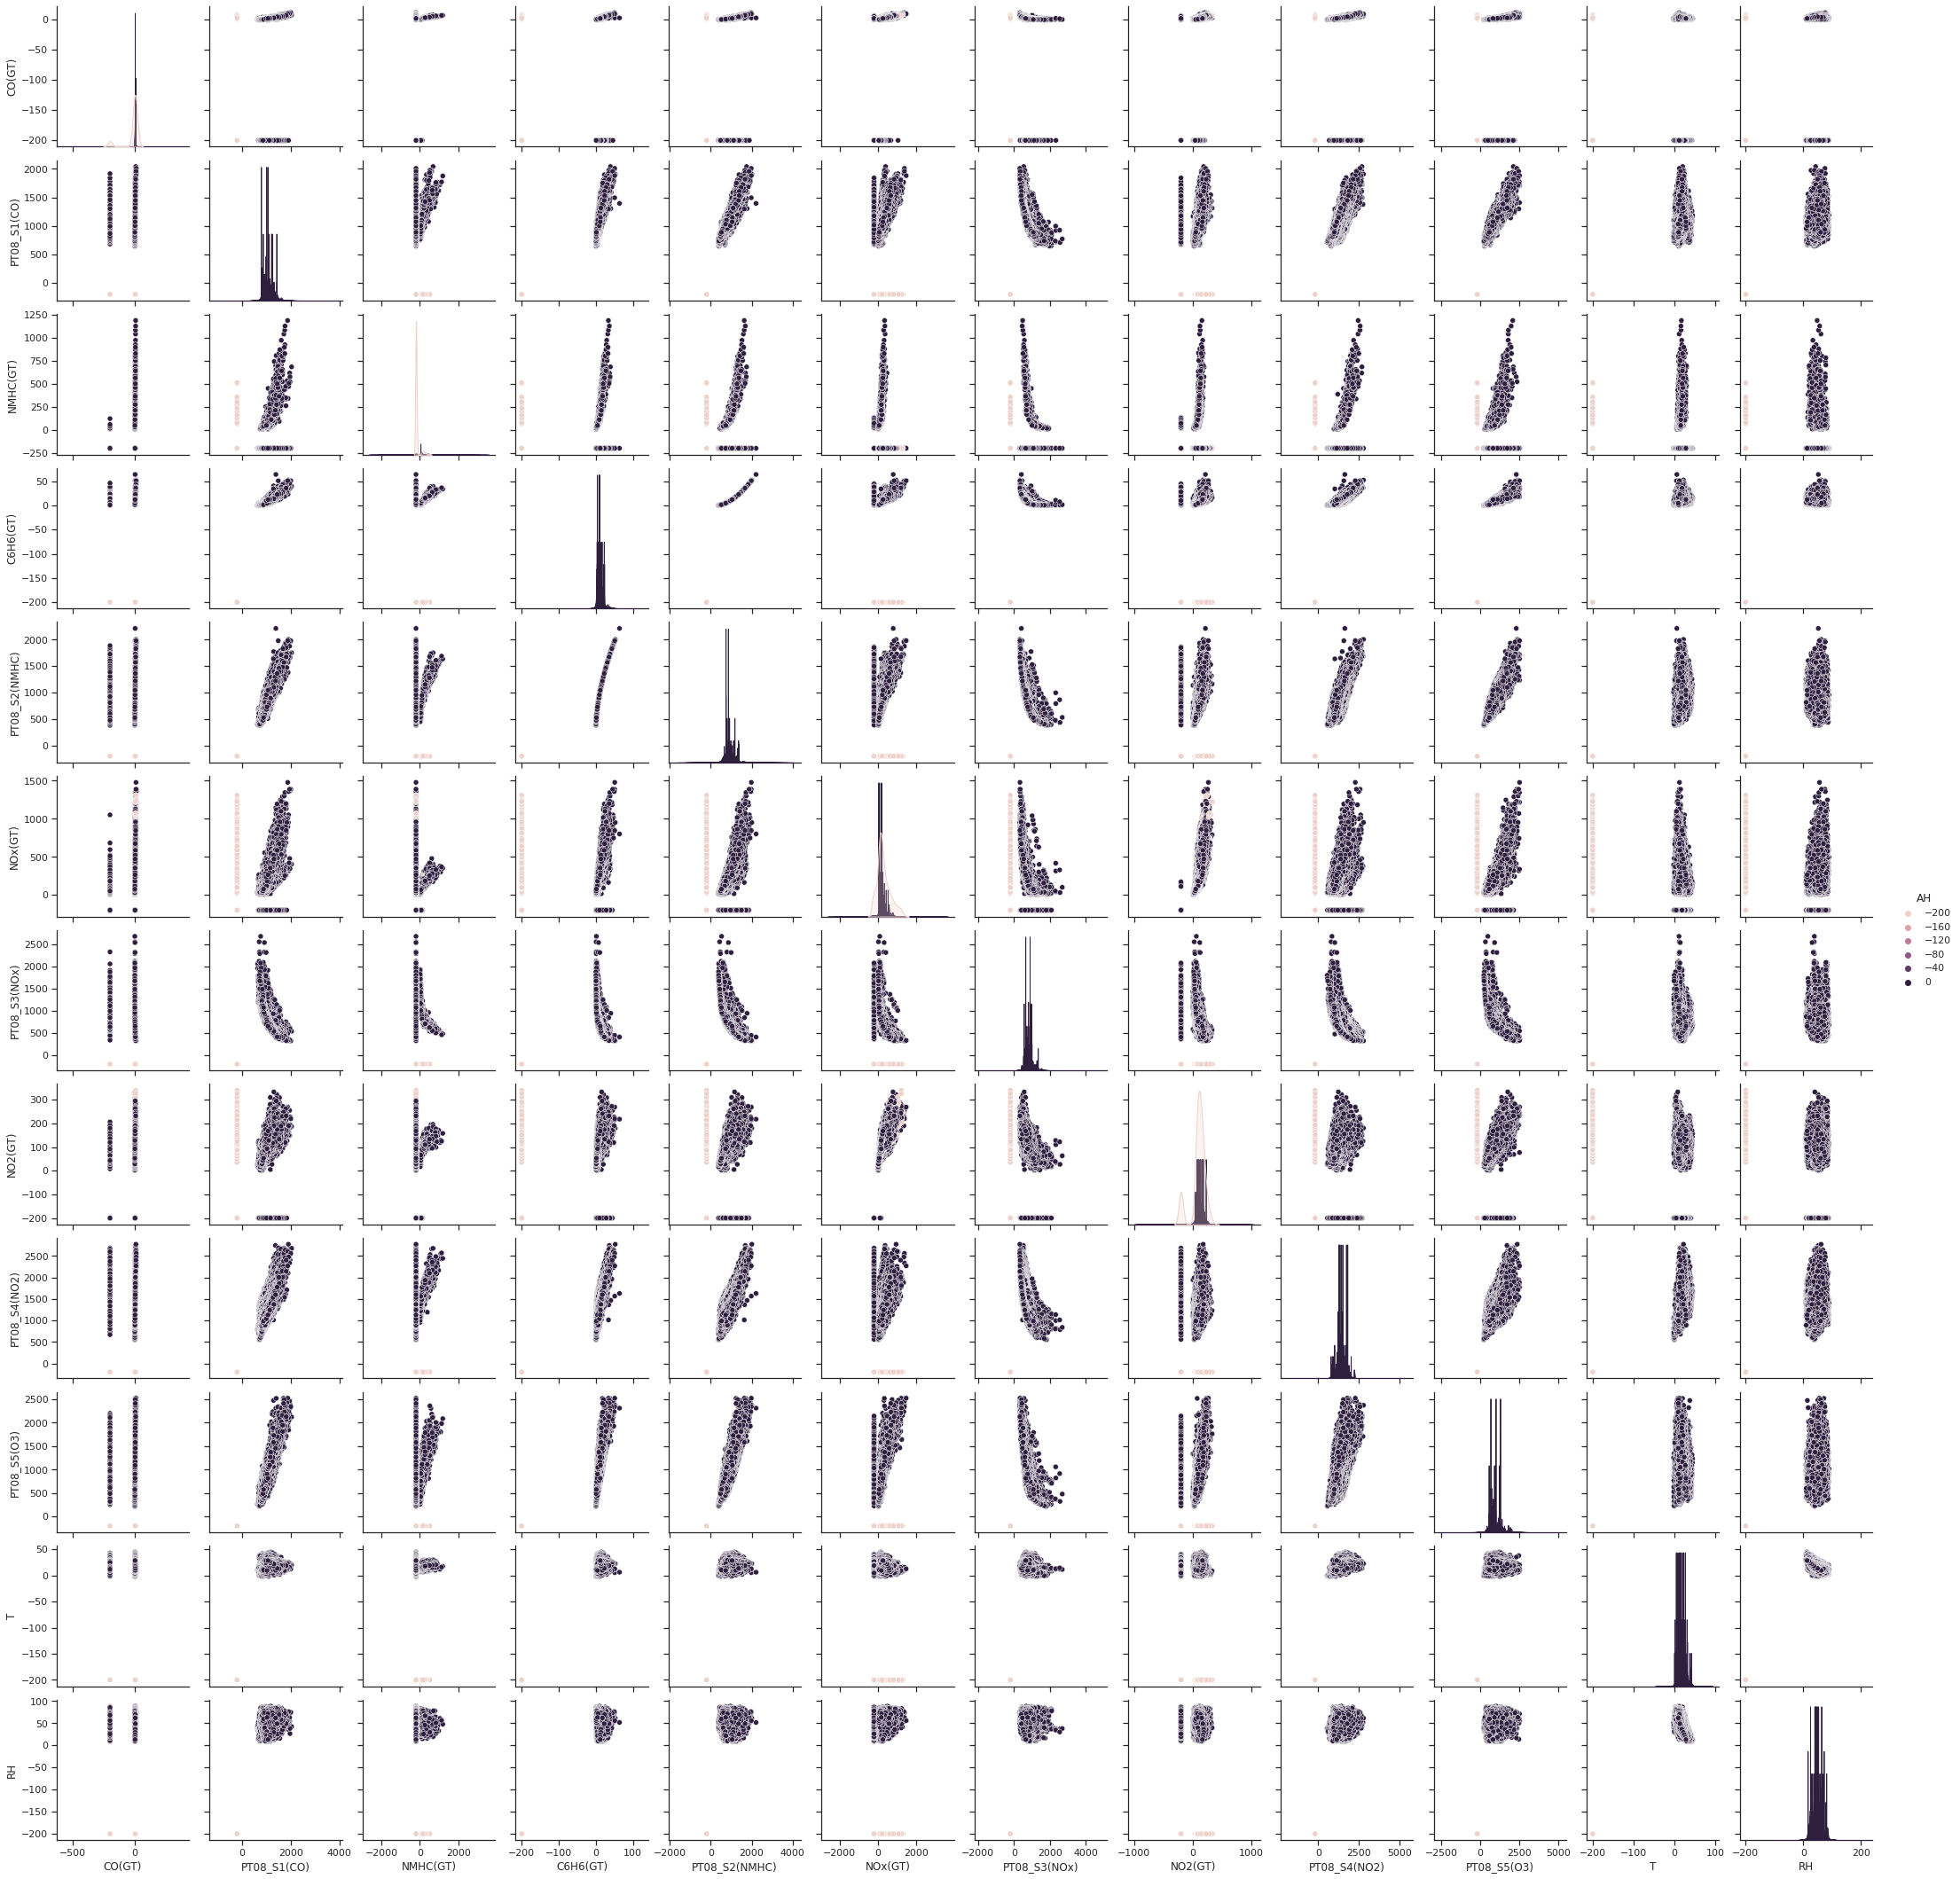

In [ ]:
import seaborn as sns
sns.set(style="ticks")

import pandas as pd

df_ = pd.read_csv('dataset.csv')
sns.pairplot(df_, hue="AH")
plt.show()


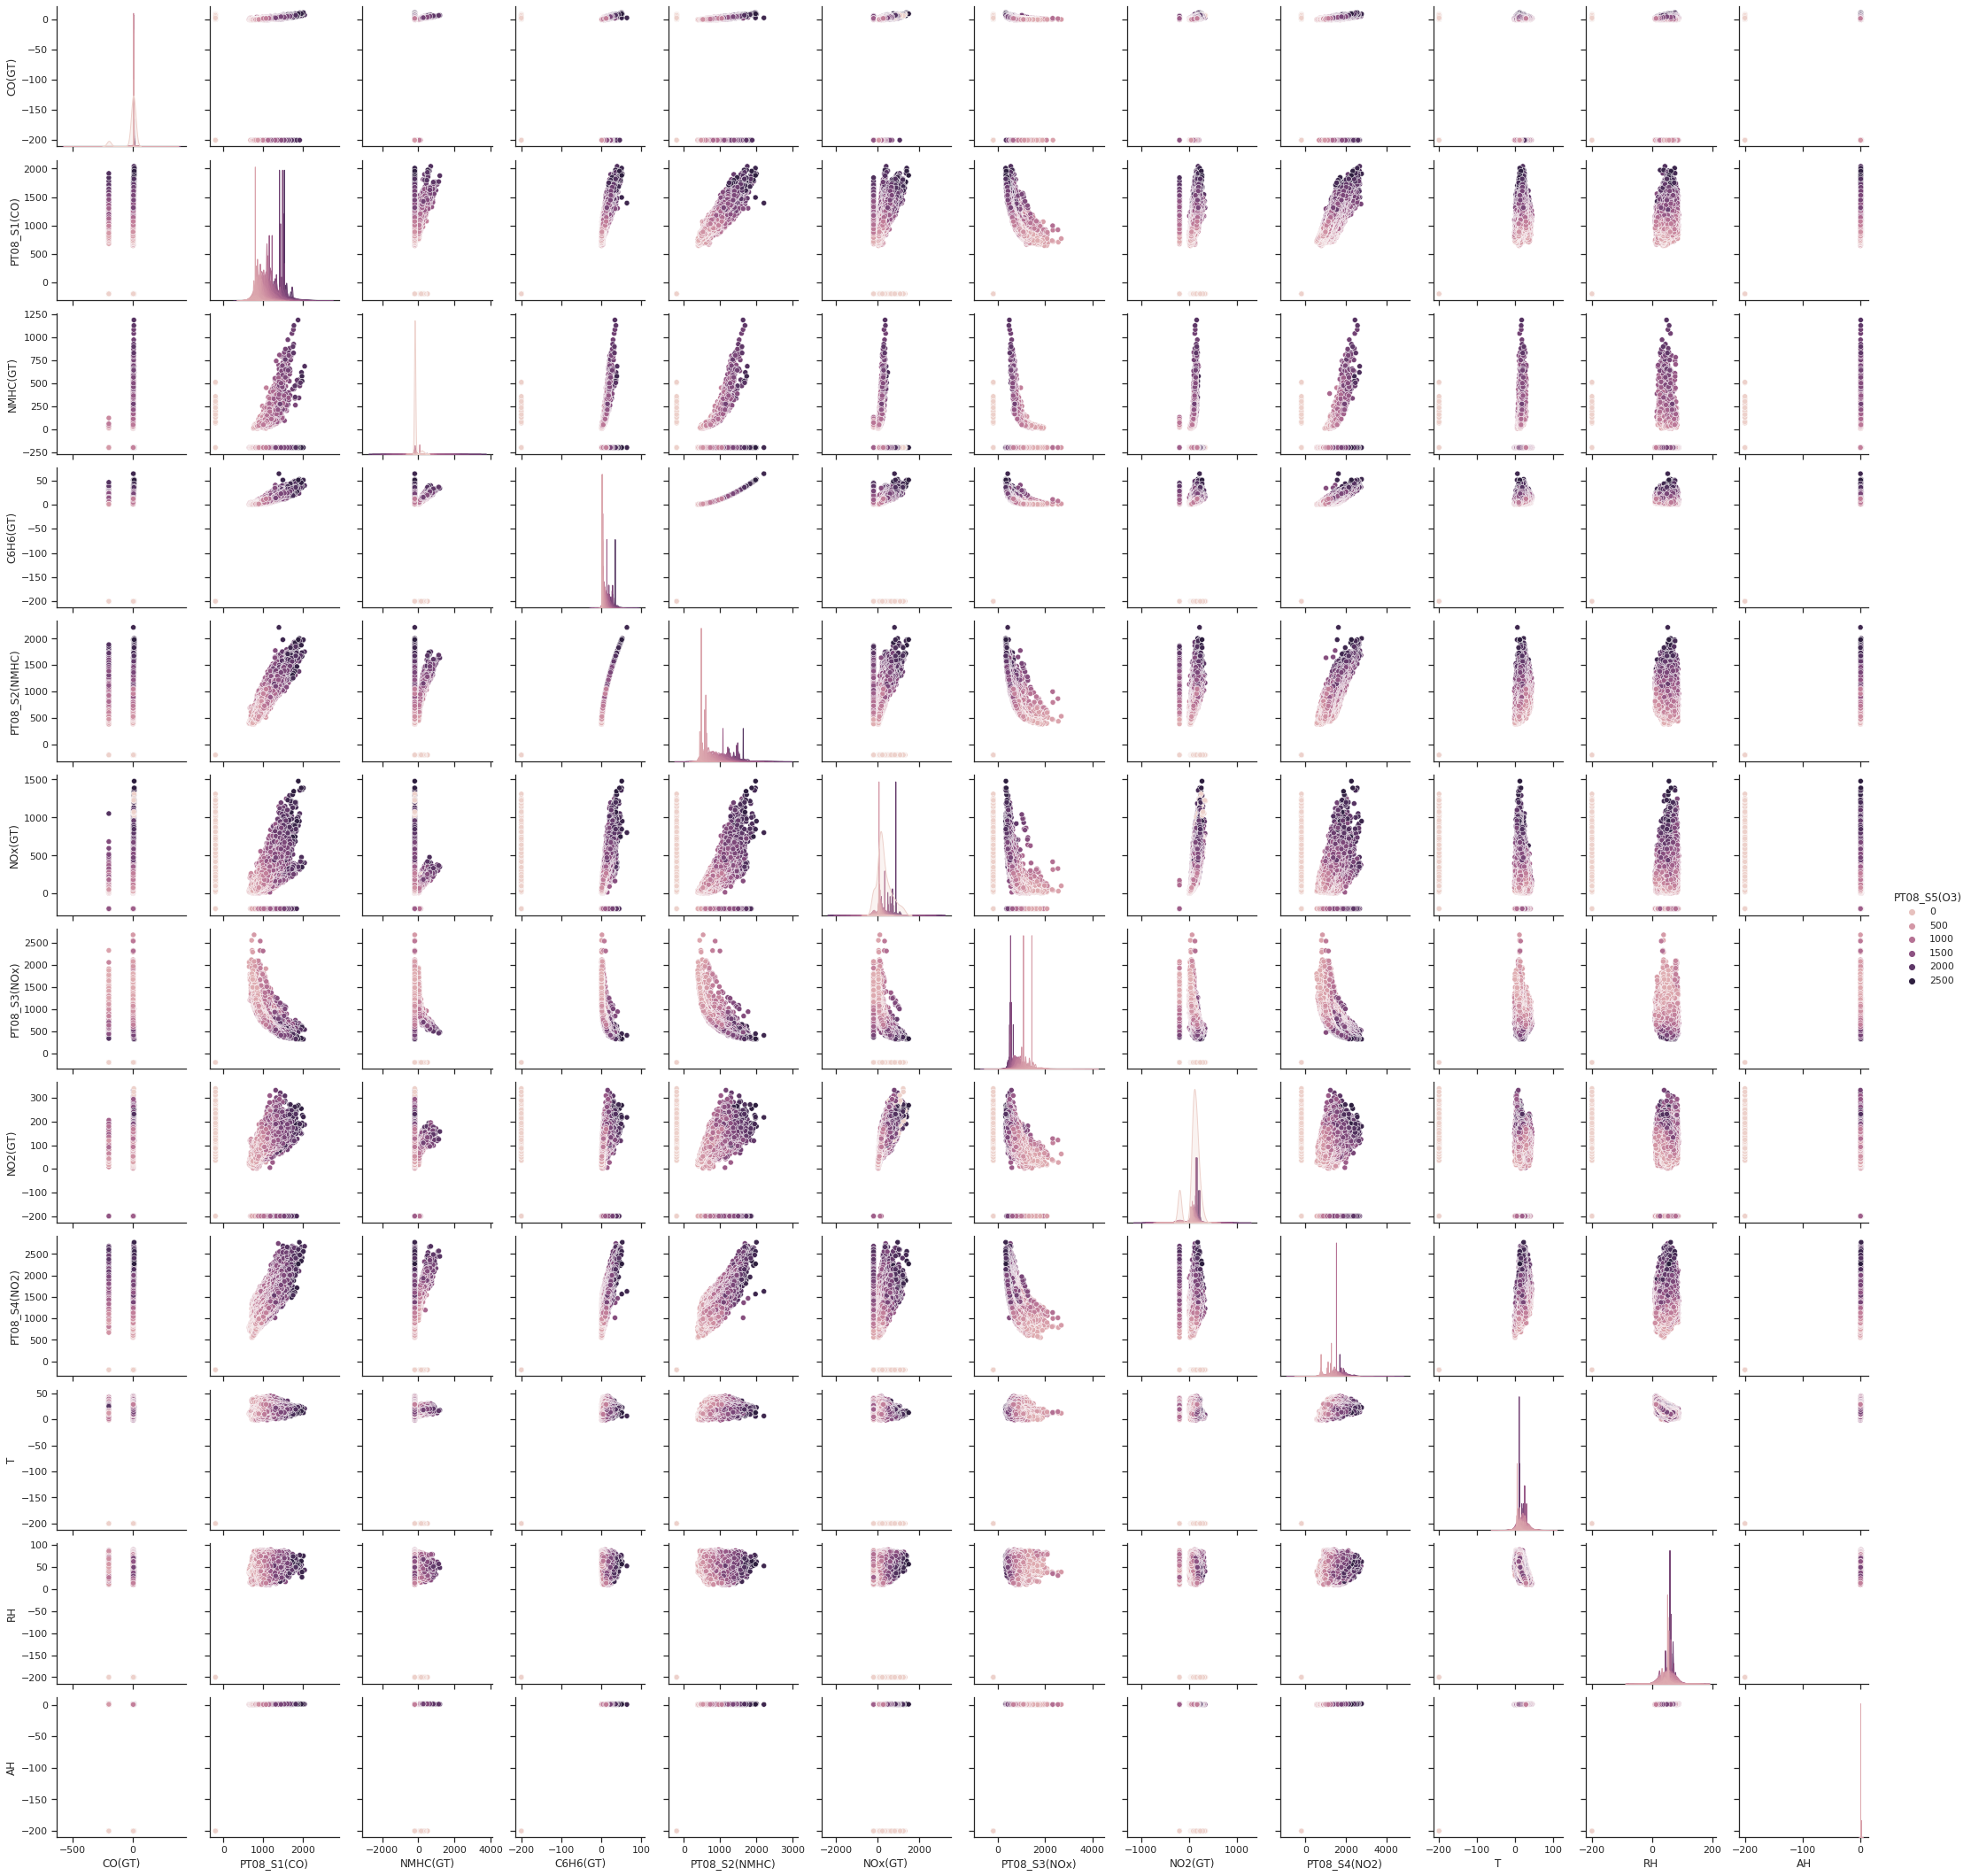

In [ ]:
sns.pairplot(df_, hue="PT08_S5(O3)")
plt.show()

In [ ]:
#valores despues del data cleaning
#print("Filas {0} Columnas {1}".format(df.count(), len(df.columns)))

#Machine learning
assemblerAtributos= VectorAssembler(inputCols=['CO(GT)','PT08_S1(CO)','NMHC(GT)','C6H6(GT)','PT08_S2(NMHC)','NOx(GT)','PT08_S3(NOx)','NO2(GT)','PT08_S4(NO2)','T','RH','AH'], outputCol= "features")
dfModificado = assemblerAtributos.transform(df)
dfModificado= dfModificado.select("features","PT08_S5(O3)")
dfModificado.show(3)
#train, test = dfModificado.randomSplit([0.8,0.2],seed=1) #80% entrenamiento 20% test

"""
# Load and parse the data
def parsePoint(line):
    values = line.split()
    return LabeledPoint(float(values[0]),
                        DenseVector([float(x.split(':')[1]) for x in values[1:]]))

sc = SparkContext('local', 'test')
data = sc.textFile("dataset.csv")
parsedData = data.map(parsePoint)
"""
#rdd = dfModificado.rdd

#dfModificado

+--------------------+-----------+
|            features|PT08_S5(O3)|
+--------------------+-----------+
|[2.6,1360.0,150.0...|     1268.0|
|[2.0,1292.0,112.0...|      972.0|
|[2.2,1402.0,88.0,...|     1074.0|
+--------------------+-----------+
only showing top 3 rows



'\n# Load and parse the data\ndef parsePoint(line):\n    values = line.split()\n    return LabeledPoint(float(values[0]),\n                        DenseVector([float(x.split(\':\')[1]) for x in values[1:]]))\n\nsc = SparkContext(\'local\', \'test\')\ndata = sc.textFile("dataset.csv")\nparsedData = data.map(parsePoint)\n'

In [ ]:
train, test = dfModificado.randomSplit([0.8,0.2],seed=1) #80% entrenamiento 20% test

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='PT08_S5(O3)', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.5393492633957733,-0.18436551796819692,3.6564174584349165,0.11332250625992249,0.8299425127625304,-0.18937516107870855,1.9236169528067433,0.17749718255722338,-4.976673671684424,-1.262790671257698,262.650621630528]
Intercept: -207.20151500229932


In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 126.905204
r2: 0.903361


In [ ]:
train.describe().show()

+-------+------------------+
|summary|       PT08_S5(O3)|
+-------+------------------+
|  count|               682|
|   mean|1049.0527859237536|
| stddev| 408.5288568410027|
|    min|             263.0|
|    max|            2359.0|
+-------+------------------+



In [ ]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","PT08_S5(O3)","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="PT08_S5(O3)",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------------+
|        prediction|PT08_S5(O3)|            features|
+------------------+-----------+--------------------+
|345.25944147213147|      331.0|[0.3,824.0,32.0,0...|
| 318.9011128521946|      352.0|[0.5,840.0,23.0,1...|
| 395.2830028653449|      376.0|[0.5,844.0,27.0,1...|
| 411.0229382900866|      406.0|[0.5,846.0,31.0,1...|
| 547.5161611751481|      677.0|[0.5,856.0,33.0,2...|
+------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.875919


In [ ]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 125.999


In [ ]:
predictions = lr_model.transform(test)
predictions.select("prediction","PT08_S5(O3)","features").show()

+------------------+-----------+--------------------+
|        prediction|PT08_S5(O3)|            features|
+------------------+-----------+--------------------+
|345.25944147213147|      331.0|[0.3,824.0,32.0,0...|
| 318.9011128521946|      352.0|[0.5,840.0,23.0,1...|
| 395.2830028653449|      376.0|[0.5,844.0,27.0,1...|
| 411.0229382900866|      406.0|[0.5,846.0,31.0,1...|
| 547.5161611751481|      677.0|[0.5,856.0,33.0,2...|
|424.62556824464434|      375.0|[0.6,830.0,41.0,1...|
|  584.369567645257|      793.0|[0.6,852.0,46.0,2...|
|434.48015101457725|      502.0|[0.6,864.0,21.0,1...|
| 572.3841823865049|      793.0|[0.6,937.0,17.0,2...|
| 405.1919491076086|      402.0|[0.7,826.0,41.0,1...|
| 515.6382357905361|      433.0|[0.7,893.0,48.0,2...|
| 589.4789146305633|      836.0|[0.7,900.0,66.0,2...|
| 539.3195164841947|      562.0|[0.7,925.0,40.0,2...|
| 683.9140390479243|      737.0|[0.7,968.0,51.0,2...|
| 600.7943151941299|      517.0|[0.8,898.0,60.0,3...|
| 612.5447422536917|      80

In [ ]:
metrics = test_result

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)
#Aplicamos la tecnica de GBT
#GPT = GBTClassifier(featuresCol="Atributos", labelCol="mpg", maxBins=41)
#GPT = GPT.fit(train)
"""
lr = LinearRegression(featuresCol="Atributos", labelCol="mpg")
model = lr.fit(train)

predictions = model.transform(test)
results = predictions.select("mpg", "prediction")

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
predictions = GPT.transform(test)
results = predictions.select("mpg", "prediction")
predictionAndLabels = results.rdd
#Calculo de metric  as
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2 * ((precision * recall) / (precision + recall))
print("Metricas del modelo GBT Classifier")
print("accuracy = {0}, precision = {1}, recall = {2}, f1 = {3}".format(accuracy, precision, recall, f1))

spark.stop()
"""

MSE = 15875.64370866411
RMSE = 125.99858613755994
R-squared = 0.8759187420962861
MAE = 102.16403662406266
Explained variance = 118550.26956250585


'\nlr = LinearRegression(featuresCol="Atributos", labelCol="mpg")\nmodel = lr.fit(train)\n\npredictions = model.transform(test)\nresults = predictions.select("mpg", "prediction")\n\nevaluator = RegressionEvaluator(\n    labelCol="label", predictionCol="prediction", metricName="rmse")\nrmse = evaluator.evaluate(predictions)\nprint("Root Mean Squared Error (RMSE) on test data = %g" % rmse)\npredictions = GPT.transform(test)\nresults = predictions.select("mpg", "prediction")\npredictionAndLabels = results.rdd\n#Calculo de metric  as\naccuracy = (cm[0][0] + cm[1][1]) / cm.sum()\nprecision = cm[0][0] / (cm[0][0] + cm[1][0])\nrecall = cm[0][0] / (cm[0][0] + cm[0][1])\nf1 = 2 * ((precision * recall) / (precision + recall))\nprint("Metricas del modelo GBT Classifier")\nprint("accuracy = {0}, precision = {1}, recall = {2}, f1 = {3}".format(accuracy, precision, recall, f1))\n\nspark.stop()\n'

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'PT08_S5(O3)')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator( labelCol="PT08_S5(O3)", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("RMSE = %g" % rmse)
dt_evaluator = RegressionEvaluator( labelCol="PT08_S5(O3)", predictionCol="prediction", metricName="mse")
mse = dt_evaluator.evaluate(dt_predictions)
print("MSE = %g" % mse)
dt_evaluator = RegressionEvaluator( labelCol="PT08_S5(O3)", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)
print("r-2 = %g" % r2)



RMSE = 125.493
MSE = 15748.5
r-2 = 0.876913
